## Project Overview
- The S&P Small Cap 600 Index consists of 600 domestic stocks chosen for market size, liquidity, (bid-asked spread, ownership, share turnover and number of no trade days) and industry group representation.
- Introduced in 1994, S&P 600 is fast becoming the preferred small cap index in the U.S. Measuring a segment of the market that is typically renowned for poor trading liquidity and financial instability.
- S&P 600 is designed to be an efficient portfolio of companies that meet specific inclusion criteria to ensure that they are investable and financially viable

## Project Goal
- I would start comparing the S&P 600 Small Cap Market Index versus the S&P 500. My question is whether the expected higher total return for the Small Cap Index makes that index more attractive even when a measure of volatility is included in the analysis.

### Project Approach:
 - To better understand if the Small Cap is more attractive than the S&P 500 we will put both indecies into a portfolio. Considering the volitility over time for each we would want to produce weights that would generate the huighest return. THisw would also wallow us to see what the best sharp ratio is for the portfolio. 
 
 - Given this we can see which weights are leaning in favor to a perferred index 

In [370]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [371]:
from pandas_datareader import data as web

In [385]:
tickers = ["^SML", "^GSPC","^DJI", "^DJUSS"]

In [386]:
data = pd.DataFrame()

In [387]:
for t in tickers:
    data[t] = web.DataReader(t, data_source= "yahoo", start = "2010-1-1")["Adj Close"]

In [388]:
data

,^SML,^GSPC,^DJI,^DJUSS
Date,,,,
2010-01-04,339.640015,1132.989990,10583.959961,443.829987
2010-01-05,338.480011,1136.520020,10572.019531,445.670013
2010-01-06,338.149994,1137.140015,10573.679688,447.049988
2010-01-07,340.390015,1141.689941,10606.860352,449.359985
2010-01-08,341.470001,1144.979980,10618.190430,451.170013
...,...,...,...,...
2020-06-05,899.330017,3193.929932,27110.980469,1069.329956
2020-06-08,917.809998,3232.389893,27572.439453,1093.280029
2020-06-09,894.770020,3207.179932,27272.300781,1069.209961


#### Coorelation
- Small Cap and 500 has a 97% correlation over a 10 year span

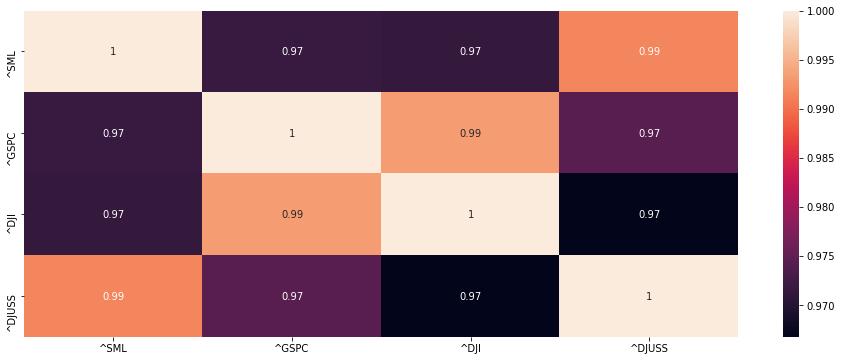

In [389]:
plt.figure(figsize=(16,6))
sns.heatmap(data.corr(), annot=True)

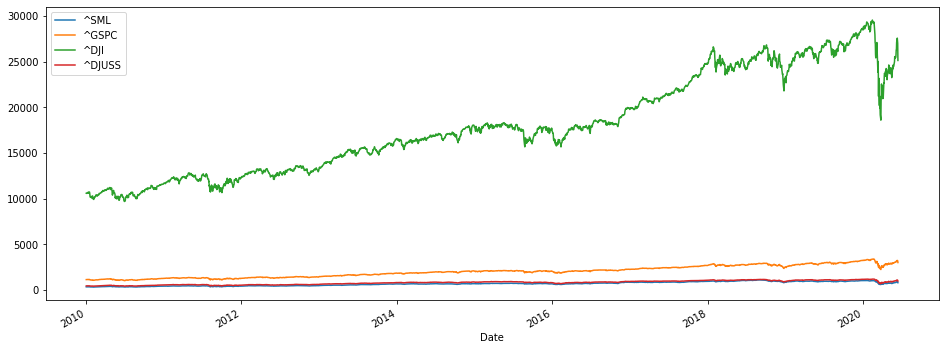

In [390]:
data.plot(figsize = (16,6))

### Daily Returns
- Will take a look at the daily returns for both indexes
- Already we can see that the Small Cap market has a higher volitility range than the S&P 500 though the average seems to close in noral standard.

In [391]:
daily_returns = data.pct_change()

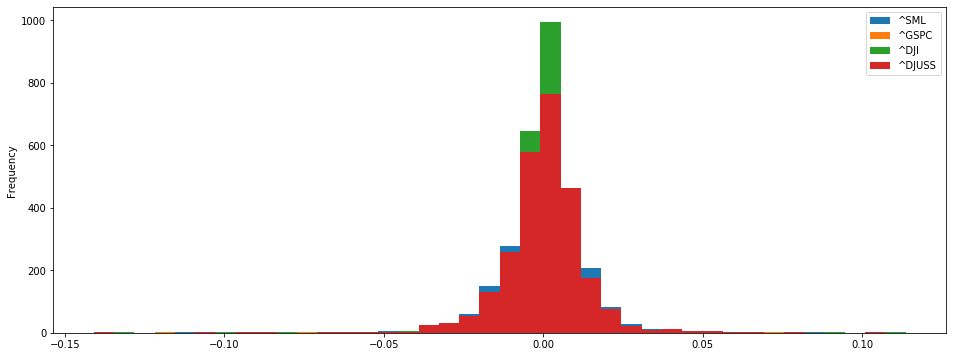

In [393]:
daily_returns.plot(kind = "hist", figsize = (16,6), bins = 40)

### Optimization 
- We will put both the Small Cap 600 and the s&P 500 into a portfolio and estimate what the returns would be
- Will need to weigh the portfolio to an optimized position for the best sharp, highest return, and the lowest vol
- Wil ltake 4000, portfolios weighed differently to see where our program feels the weights are best suited

In [394]:
n_portfolios = 4000
all_weights = np.zeros((n_portfolios, len(daily_returns.columns)))
all_sharp = np.zeros(n_portfolios)
all_vol = np.zeros(n_portfolios)
all_returns = np.zeros(n_portfolios)


for ind in range(n_portfolios):
    weii = np.array(np.random.random(len(daily_returns.columns)))
    weii = weii/weii.sum()
    all_weights[ind:,] = weii
    
    all_returns[ind] = np.sum(daily_returns.mean() * weii) * 252
    all_vol[ind] = np.sqrt(np.dot(weii.T, np.dot(daily_returns.cov() * 252, weii)))
    all_sharp[ind] = all_returns[ind]/all_vol[ind]

### max_sharp

In [395]:
max_sharp = all_sharp.argmax()

## lowest vol

In [396]:
lowest_vol = all_vol.argmin()

### max_returns 

In [397]:
max_returns = all_returns.argmax()

### Plotting the frontier 

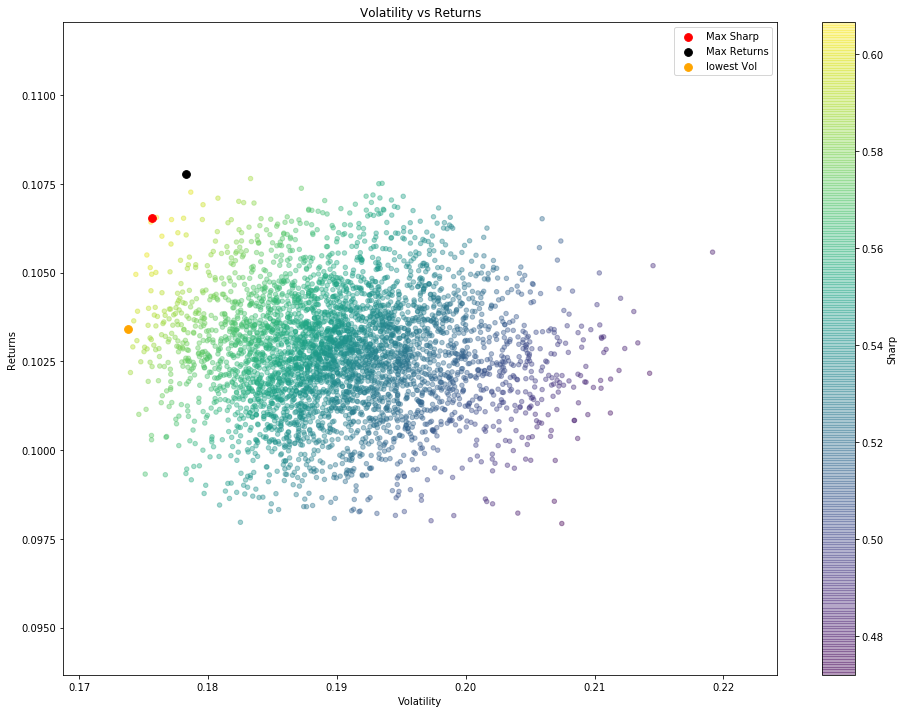

In [398]:
plt.figure(figsize= (16,12))
plt.scatter(all_vol, all_returns, c = all_sharp, alpha=0.4, s = 20)
plt.colorbar(label = "Sharp")
plt.scatter(all_vol[max_sharp], all_returns[max_sharp], c = "r",s = 60, label = "Max Sharp")
plt.scatter(all_vol[max_returns], all_returns[max_returns], c = "black",s = 60, label = "Max Returns")
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c = "orange",s = 60, label = "lowest Vol")
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.title("Volatility vs Returns")
plt.legend()

## Summary 
- Using Randomly allocatied weights we see that the best way to get the highest returns is to alloacte 95% to the s&P 500

In [399]:
all_weights[max_returns]

array([0.1096556 , 0.81503514, 0.06156185, 0.01374741])

In [400]:
all_weights[lowest_vol]

array([0.0094364 , 0.48201559, 0.50694684, 0.00160117])

In [401]:
all_weights[max_sharp]

array([0.02018049, 0.76754337, 0.17729089, 0.03498525])

### Mathmatically
 - Will use scipy to get the efficient frontier

In [402]:
from scipy.optimize import minimize

In [403]:
def get_ret_vol_sharp(weights):
    weights =np.array(weights)
    ret = np.sum(daily_returns.mean() * weights * 252)
    vol = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))
    sharp = ret/vol
    return np.array([ret,vol,sharp])

In [404]:
def min_shp(weights):
    return get_ret_vol_sharp(weights)[2] * -1

In [405]:
def check_weights(weights):
    return np.sum(weights) - 1

In [408]:
initial_guess = [.25,] * len(daily_returns.columns)

In [409]:
initial_guess

[0.25, 0.25, 0.25, 0.25]

##### initial_guess

In [410]:
constraint = {"type":"eq", "fun": check_weights}

In [411]:
bou = ((0,1), ) * len(daily_returns.columns)

In [412]:
bou

((0, 1), (0, 1), (0, 1), (0, 1))

In [413]:
best_port = minimize(min_shp, initial_guess, method="SLSQP",  bounds= bou, constraints=constraint)

In [414]:
best_port

     fun: -0.6217843612355438
     jac: array([1.07295550e-01, 7.45058060e-09, 4.28491905e-02, 1.41992763e-01])
 message: 'Optimization terminated successfully.'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0., 1., 0., 0.])

### Scipy  returns on Return, Vol, and Sharp for what is to be the best portfolio

In [415]:
get_ret_vol_sharp(best_port.x)

array([0.10889917, 0.17513977, 0.62178436])

In [416]:
frontier_y = np.linspace(.0975, .1080, 250)

In [417]:
frontier_vol = []

In [418]:
frontier_weights = []

In [419]:
def lower_Vol(weights):
    return get_ret_vol_sharp(weights)[1]

In [420]:
for potential_return in frontier_y:
    con = ({"type":"eq", "fun": check_weights}, {"type": "eq", "fun": lambda x: get_ret_vol_sharp(x)[0] - potential_return})
    result = minimize(lower_Vol, initial_guess, method="SLSQp", constraints=con, bounds=bou)
    frontier_vol.append(result["fun"])

In [421]:
result

     fun: 0.17473120229852143
     jac: array([0.20088337, 0.17511227, 0.17055903, 0.19658584])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.        , 0.91630918, 0.08369082, 0.        ])

In [422]:
get_ret_vol_sharp(result.x)

array([0.108     , 0.1747312 , 0.61809224])

## Summary 
- THe Max vol for this portfolio us 17%and best sharo is .62, best return is approximaptely 11%

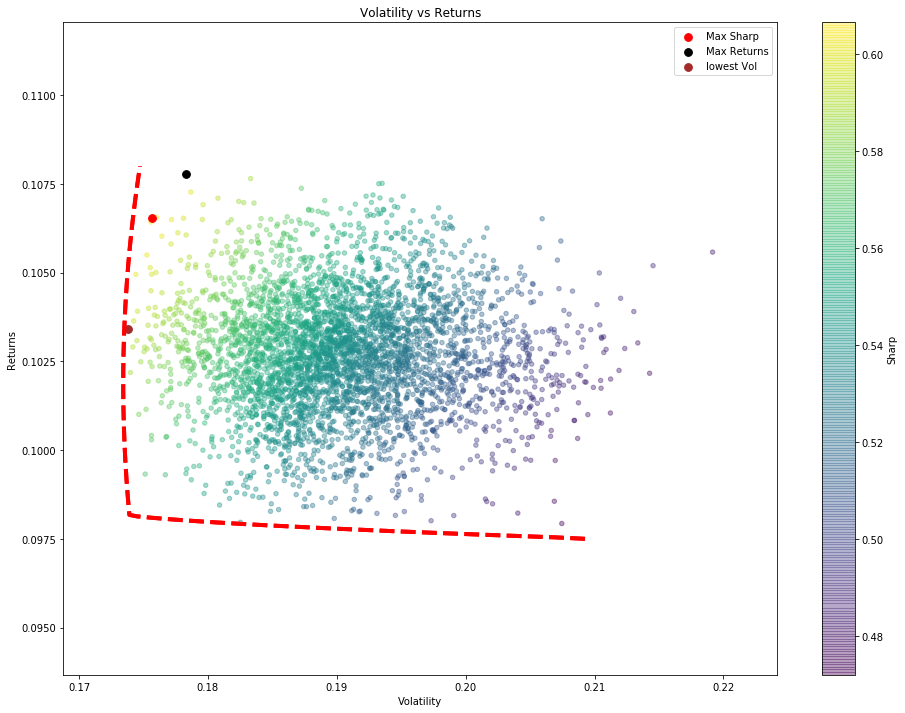

In [423]:
plt.figure(figsize= (16,12))
plt.scatter(all_vol, all_returns, c = all_sharp, alpha=0.4, s = 20)
plt.colorbar(label = "Sharp")
plt.scatter(all_vol[max_sharp], all_returns[max_sharp], c = "r",s = 60, label = "Max Sharp")
plt.scatter(all_vol[max_returns], all_returns[max_returns], c = "black",s = 60, label = "Max Returns")
plt.scatter(all_vol[lowest_vol], all_returns[lowest_vol], c = "brown",s = 60, label = "lowest Vol")
plt.plot(frontier_vol, frontier_y, ls = "--", lw = 4, c = "r")

plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.title("Volatility vs Returns")
plt.legend()
plt.plot(frontier_vol, frontier_y, ls = "--", lw = 4, c = "r")

### in summary -> the Volatility of all 5 markets does not play a key role in determaining if one index is more attractive. This is due to the fact that the volatility of the 3 indexes over the last 10 years. What than plays is the daily returns or each index. 

In [424]:
daily_returns.std() * 252 ** 0.5

^SML      0.222672
^GSPC     0.175140
^DJI      0.173912
^DJUSS    0.209261
dtype: float64

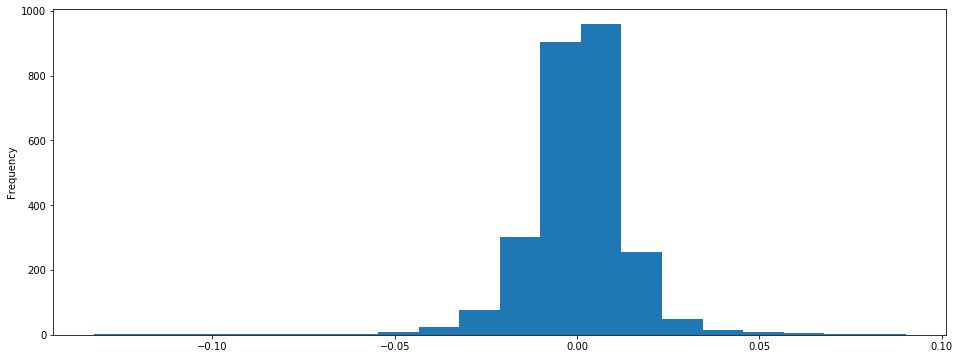

In [425]:
daily_returns["^SML"].plot(kind = "hist", bins = 20, figsize = (16,6))

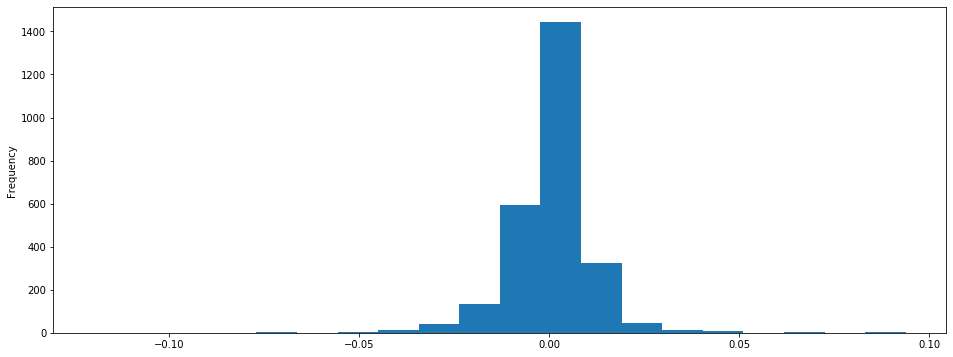

In [426]:
daily_returns["^GSPC"].plot(kind = "hist", bins = 20, figsize = (16,6))

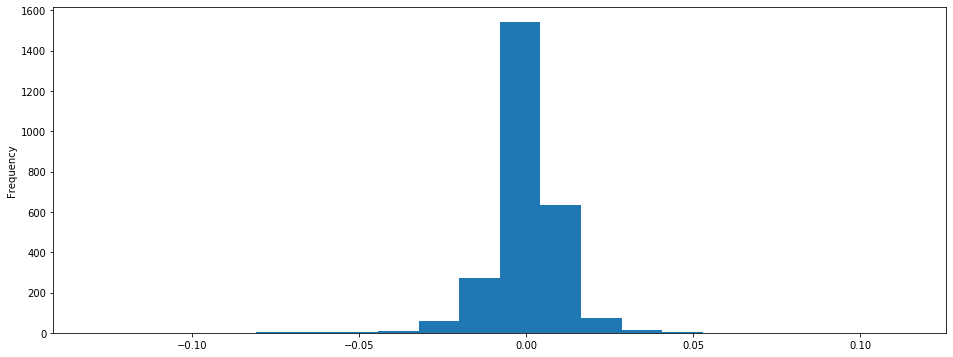

In [367]:
daily_returns["^DJI"].plot(kind = "hist", bins = 20, figsize = (16,6))

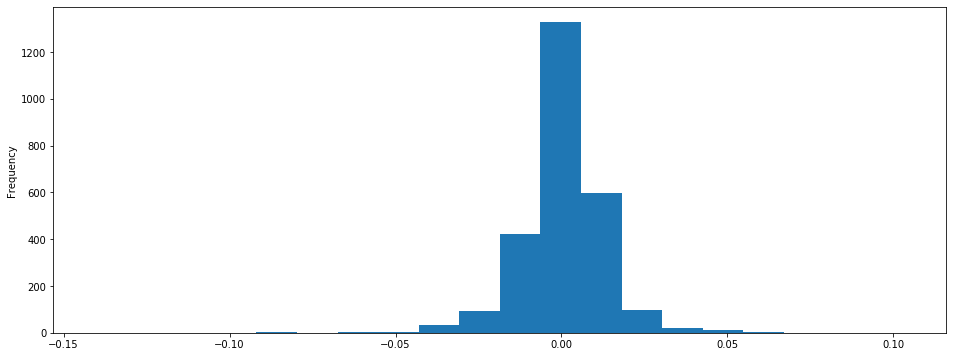

In [368]:
daily_returns["^DJUSS"].plot(kind = "hist", bins = 20, figsize = (16,6))

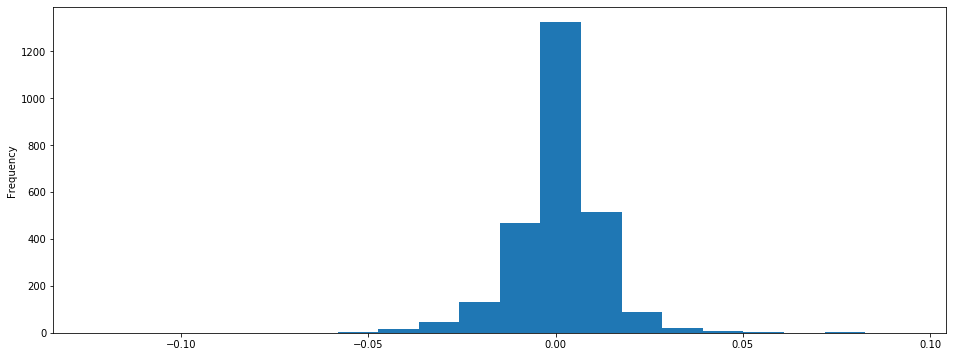

In [369]:
daily_returns["^IXIC"].plot(kind = "hist", bins = 20, figsize = (16,6))